In [1]:
import torch
import torch.nn as nn

import torch.utils.data
from torch.utils.data.dataloader import DataLoader

import torchvision
import torchsummary

import matplotlib.pyplot as plt
import ipywidgets

# import wandb

from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
batch_size = 64
number_of_layers = 2
latent_space_size = 3
epochs = 20
learning_rate = 0.001

# config = {
#     "batch_size": batch_size,
#     "number_of_layers": number_of_layers,
#     "latent_space_size": latent_space_size,
#     "epochs": epochs,
#     "learning_rate": learning_rate,
# }

# wandb.init(project="wiktor-vrije-learn.autoencoder.basic", config=config, save_code=False)

In [3]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

dataset = torchvision.datasets.MNIST("~/pytorch/data", train=True, transform=transforms)

In [4]:
train_data, validation_data, test_data = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])
validation_data_loader, test_data_loader = DataLoader(validation_data, batch_size), DataLoader(test_data, batch_size)

In [5]:
data_iter = iter(dataset)
data_x, data_y = next(data_iter)
print(torch.max(data_x), torch.min(data_x))

tensor(1.) tensor(0.)


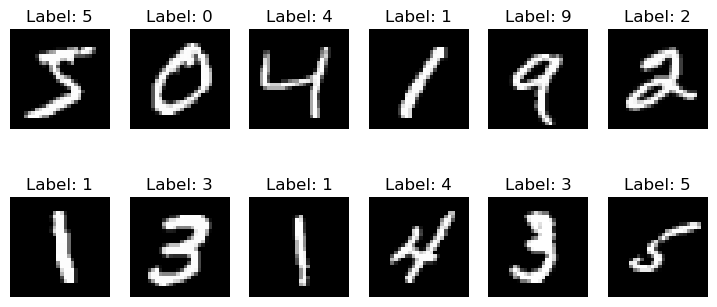

In [6]:
num_col = 6
num_row = 2
offset = 0

data_iter = iter(dataset)
for _ in range(offset):
    next(data_iter)


_, axs = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i, ax in enumerate(axs.flatten()):
    data_x, data_y = next(data_iter)

    img = data_x.squeeze()
    ax.set_title(f"Label: {data_y}")
    ax.imshow(img, cmap="grey")
    ax.set_axis_off()

plt.show()

In [7]:
from typing import List


class MNISTAutoencoder(nn.Module):
    def __init__(self, latent_space_size: int, number_of_layers: int):
        super().__init__()

        self.input_size = 28 * 28
        self.latent_space_size = latent_space_size
        self.number_of_layers = number_of_layers

        assert self.input_size > self.latent_space_size

        # Sometimes we are unable to nicely divide the amount of compression we have to do
        # between layers. We are left with a nasty decimal reminder.
        # For example:
        # latent_space_size = 6
        # number_of_layers = 4
        # (784 - 6) / 4 = 194,5
        # We would need to compress the output by 194,5 on each layer. We can't have half of a neuron can we?
        # In this loop we are trying to accumulate this reminder and distribute it weever possible.
        # This way the amount of compression we do per-layer is ~constant.

        reduce_by_n_features_per_layer = (self.input_size - self.latent_space_size) // self.number_of_layers
        reduce_by_n_features_per_layer_reminder = (self.input_size - self.latent_space_size) / self.number_of_layers - reduce_by_n_features_per_layer

        previous_layer_out_features = self.input_size
        encoder_layers_out_features = []
        reminder = 0
        for _ in range(number_of_layers - 1):
            reduce_by_n = reduce_by_n_features_per_layer
            reminder += reduce_by_n_features_per_layer_reminder
            if reminder >= 1:
                reminder -= 1
                reduce_by_n += 1

            layer_out_features = previous_layer_out_features - reduce_by_n

            previous_layer_out_features = layer_out_features
            encoder_layers_out_features.append(layer_out_features)

        # Regardless of the reminder logic, we want to have our latent space size set
        # to what user intended.
        encoder_layers_out_features.append(self.latent_space_size)

        encoder_modules: List[nn.Module] = [
            nn.Flatten(),
        ]

        previous_layer_out_features = self.input_size
        for layer_out_features in encoder_layers_out_features:
            encoder_modules.append(nn.Linear(previous_layer_out_features, layer_out_features))
            previous_layer_out_features = layer_out_features

            is_last_layer = layer_out_features == self.latent_space_size
            if not is_last_layer:
                encoder_modules.append(nn.ReLU())

        encoder_modules.append(nn.Sigmoid())

        decoder_modules: List[nn.Module] = []

        decoder_layers_out_features = list(reversed(encoder_layers_out_features))
        decoder_layers_out_features = decoder_layers_out_features[1:]
        decoder_layers_out_features.append(self.input_size)

        previous_layer_out_features = self.latent_space_size
        for layer_out_features in decoder_layers_out_features:
            decoder_modules.append(nn.Linear(previous_layer_out_features, layer_out_features))
            previous_layer_out_features = layer_out_features

            is_last_layer = layer_out_features == self.input_size
            if not is_last_layer:
                decoder_modules.append(nn.ReLU())

        decoder_modules.append(nn.Unflatten(-1, (1, 28, 28)))

        self.encoder = nn.Sequential(*encoder_modules)
        self.decoder = nn.Sequential(*decoder_modules)

    def __str__(self):
        return f"MNISTAutoencoder:\n    Latent size: {self.latent_space_size}, Layers count: {self.number_of_layers}"

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
model = MNISTAutoencoder(latent_space_size, number_of_layers)
# wandb.watch(model)

In [9]:
def calculate_loss(model, data_loader):
    loss_function = torch.nn.MSELoss()

    running_loss = 0
    for images, _ in data_loader:
        true_images = images
        predicted_images = model(true_images)
        running_loss += loss_function(predicted_images, true_images)

    return running_loss / len(data_loader)


def train_model(model: nn.Module, learning_rate, epochs, train_data_loader: DataLoader):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = torch.nn.MSELoss()

    for epoch in (mb := master_bar(range(epochs))):
        running_loss = 0
        for bach_of_data_images, _ in (pb := progress_bar(train_data_loader, parent=mb)):
            true_images = bach_of_data_images
            predicted = model(true_images)

            loss = loss_function(predicted, true_images)
            loss_item = loss.item()
            running_loss += loss_item
            pb.comment = f"Loss: {loss_item}"

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # wandb.log(
        #     {
        #         "epoch": epoch,
        #         "loss": running_loss / len(train_data_loader),
        #         "validation_loss": calculate_loss(model, validation_data_loader),
        #         "test_loss": calculate_loss(model, test_data_loader),
        #     }
        # )
        running_loss = 0


print(f"Training model: {model}")
train_data_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Set model to training mode.
model.train()
train_model(model, learning_rate, epochs, train_data_loader)

# Set model to evaluation mode.
model.eval()

Training model: MNISTAutoencoder:
    Latent size: 3, Layers count: 2


MNISTAutoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=394, bias=True)
    (2): ReLU()
    (3): Linear(in_features=394, out_features=3, bias=True)
    (4): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=394, bias=True)
    (1): ReLU()
    (2): Linear(in_features=394, out_features=784, bias=True)
    (3): Unflatten(dim=-1, unflattened_size=(1, 28, 28))
  )
)

In [10]:
validation_loss = calculate_loss(model, validation_data_loader)
test_loss = calculate_loss(model, test_data_loader)

print(f"Validation loss: {validation_loss}")
print(f"Test loss: {test_loss}")
print(f"For model {model}")
print()

Validation loss: 0.03583773225545883
Test loss: 0.03615976497530937
For model MNISTAutoencoder:
    Latent size: 3, Layers count: 2



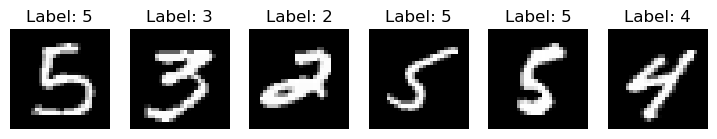

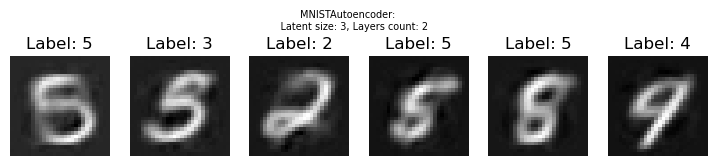

In [11]:
from random import randint

data_iter = iter(test_data_loader)
offset = randint(0, 10)
num_col = 6
num_row = 1

for _ in range(offset):
    next(data_iter)
data_x, data_y = next(data_iter)


def plot_images(data_x, title=None):
    fig, axs = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    if title:
        fig.suptitle(title, fontsize=7)

    for i, ax in enumerate(axs.flatten()):
        img = data_x[i].squeeze()
        ax.set_title(f"Label: {data_y[i]}")

        ax.imshow(img, cmap="grey")
        ax.set_axis_off()

    plt.show()


plot_images(data_x)
plot_images(model(data_x).detach().numpy(), str(model))

This is the place where you can play with the model!

In [12]:
# We used the sigmoid function, so the repr in the latent space is between 0 and 1.
eir = latent_space_ipywidgets_range = (0, 1, 0.001)


def play_with_model(model: MNISTAutoencoder):
    latent_space_params_dict = {}
    for i in range(model.latent_space_size):
        latent_space_params_dict[f"P{i+1}"] = eir

    def update(**kwargs):
        latent_space_array = list(kwargs.values())
        encoded = torch.tensor(latent_space_array).reshape(1, model.latent_space_size)
        decoded_image = model.decoder(encoded)
        plt.imshow(decoded_image.detach().numpy()[0][0], cmap="grey")

    ipywidgets.interact(update, **latent_space_params_dict)


play_with_model(model)

interactive(children=(FloatSlider(value=0.0, description='P1', max=1.0, step=0.001), FloatSlider(value=0.0, de…